# Modelo de Regressão para Dados em Painel

Aplicação sobre os dados tratados e categorizados por empreendimento para extrair as relações de cada categoria de empreendimento com o número de mortes e feridos.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from linearmodels.panel import PanelOLS, compare, RandomEffects, PooledOLS
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import f as scipyStatsF
from statsmodels.stats.outliers_influence import variance_inflation_factor
import os

import warnings
warnings.filterwarnings('ignore')

# Funções e importações

## Bases de dados

In [26]:
df_agrup_munic_ano = pd.read_csv('../dados/tratados/agrupamento_empreend_acidentes_por_municipio_e_ano_sem_nulos.csv')
df_agrup_munic_ano_inicial = df_agrup_munic_ano.copy() # tabela inicial usada como exemplo nos testes de matriz LD e LI
df_empreend = pd.read_csv('../dados/tratados/simu_carteira_empreendimentos_nulos_tratados.csv')

In [27]:
print("Tamanho da base",df_agrup_munic_ano.shape)
df_agrup_munic_ano.head()

Tamanho da base (20700, 105)


,Código IBGE,ano,vlr_investimento,Populacao,pop_beneficiada,num_total_empreendimentos,aux_emp_metro,aux_emp_metro_vlr_investimento,aux_emp_pavimentacao,aux_emp_pavimentacao_vlr_investimento,...,taxa_mun_ciclista_feridos,taxa_mun_motociclista_feridos,taxa_mun_automovel_feridos,taxa_mun_veiculo_pesado_feridos,taxa_mun_onibus_feridos,taxa_mun_outros_feridos,taxa_mun_triciclo_mortes,taxa_mun_caminhonete_mortes,taxa_mun_triciclo_feridos,taxa_mun_caminhonete_feridos
0,1100015.0,2011.0,1530000.00,24228.0,1841.0,2,0,0.0,2,1530000.00,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1,1100023.0,2012.0,1787781.82,92747.0,2087.0,2,0,0.0,0,0.00,...,0.007547,0.177903,0.002156,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2,1100023.0,2014.0,36842105.26,102860.0,43512.0,1,0,0.0,1,36842105.26,...,0.000000,0.055415,0.000000,0.0,0.000972,0.000000,0.0,0.0,0.0,0.0
3,1100031.0,2011.0,265850.00,6221.0,306.0,1,0,0.0,1,265850.00,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
4,1100049.0,2010.0,2821324.40,78574.0,3343.0,3,0,0.0,2,2290724.40,...,0.001273,0.006363,0.000000,0.0,0.000000,0.001273,0.0,0.0,0.0,0.0


In [28]:
colunas_obrigatorias = ['total_mortes', 'total_feridos', 'Código IBGE', 'ano']

colunas_empreendimentos = list(df_agrup_munic_ano.filter(regex='^aux_emp.*vlr_investimento$').columns) + ['vlr_investimento_per_capita']
colunas_selecionadas = set(colunas_empreendimentos + colunas_obrigatorias)
df_agrup_munic_ano = df_agrup_munic_ano[colunas_selecionadas]
df_agrup_munic_ano.columns

Index(['aux_emp_parque_vlr_investimento',
       'aux_emp_pavimentacao_vlr_investimento', 'Código IBGE',
       'aux_emp_vlt_vlr_investimento', 'aux_emp_aeroporto_vlr_investimento',
       'aux_emp_refrota_vlr_investimento',
       'aux_emp_calcamento_vlr_investimento',
       'aux_emp_sinalizacao_vlr_investimento', 'vlr_investimento_per_capita',
       'aux_emp_terminal_vlr_investimento',
       'aux_emp_calcadas_vlr_investimento', 'aux_emp_rapido_vlr_investimento',
       'aux_emp_praca_vlr_investimento', 'total_feridos',
       'aux_emp_revitalizacao_vlr_investimento',
       'aux_emp_ciclovia_vlr_investimento', 'aux_emp_onibus_vlr_investimento',
       'aux_emp_metro_vlr_investimento', 'aux_emp_ponte_vlr_investimento',
       'aux_emp_drenagem_vlr_investimento',
       'aux_emp_recapeamento_vlr_investimento',
       'aux_emp_asfalto_vlr_investimento', 'aux_emp_corredor_vlr_investimento',
       'aux_emp_sarjeta_vlr_investimento', 'total_mortes', 'ano',
       'aux_emp_ferrovia_vlr_

## Funções

In [29]:
def matrix_LI(matrix):
    """
    Seleciona colunas linearmente independentes de uma matriz de entrada.

    Esta função remove colunas com todos os valores zero, adiciona uma constante e, em seguida, 
    seleciona colunas linearmente independentes, começando com as duas primeiras colunas da matriz original.

    Parâmetros:
    matrix (pd.DataFrame): O DataFrame de entrada, contendo as colunas e um MultiIndex.

    Retorna:
    pd.DataFrame: Um novo DataFrame contendo apenas colunas linearmente independentes, 
    preservando o MultiIndex original.
    """
    # Removendo colunas com todos os valores zero
    matrix = matrix.loc[:, (matrix != 0).any(axis=0)]
    matrix = sm.add_constant(matrix).astype(float)

    # Selecionar as duas primeiras colunas da matriz original
    initial_columns = matrix.iloc[:, :2]
    remaining_matrix = matrix.iloc[:, 2:].values

    # Inicializa a matriz LI e lista de índices
    LI_matrix = initial_columns.values
    cols_li = initial_columns.columns.tolist()

    for i in range(remaining_matrix.shape[1]):
        # Adiciona uma coluna candidata
        nova_coluna = remaining_matrix[:, i].reshape(-1, 1)
        # Concatena a nova coluna à matriz de colunas LI
        temp_matrix = np.hstack([LI_matrix, nova_coluna])
        # Verifica o posto da nova matriz
        if np.linalg.matrix_rank(temp_matrix) > np.linalg.matrix_rank(LI_matrix):
            LI_matrix = temp_matrix
            cols_li.append(matrix.columns[i + 2])
        # Verificar se já temos o número máximo de colunas LI (igual ao número de linhas)
        if LI_matrix.shape[1] == LI_matrix.shape[0]:
            break

    # Convertendo de volta para DataFrame do Pandas com o MultiIndex original
    new_matrix = pd.DataFrame(LI_matrix, index=matrix.index, columns=cols_li)
    
    return new_matrix

In [30]:
def prepare_panel_data(df, selected_columns=[], check_rank=True):
    """
    Prepara os dados de um DataFrame para análise em painel.

    Parâmetros:
    ----------
    df : pd.DataFrame
        DataFrame contendo os dados a serem preparados.
    selected_columns : list, opcional
        Lista de colunas selecionadas para a análise. Se não fornecida, todas as colunas numéricas serão utilizadas.
    check_rank : bool, opcional
        Flag para indicar se a verificação do posto da matriz deve ser realizada.

    Retornos:
    --------
    df_panel : pd.DataFrame
        DataFrame preparado para análise em painel, com as colunas independentes, dependentes e eixos do painel selecionados.
    X : pd.DataFrame
        DataFrame contendo as variáveis independentes com uma constante adicionada.
    y1 : pd.Series
        Série contendo os valores da variável dependente 'total_mortes'.
    y2 : pd.Series
        Série contendo os valores da variável dependente 'total_feridos'.
    """

    # Fixos
    eixos_painel = ['Código IBGE', 'ano']
    y1_name = 'total_mortes'
    y2_name = 'total_feridos'

    if len(selected_columns) == 0:
        selected_columns = df.select_dtypes(include='number').columns.tolist()

    df_panel = df[pd.unique([y1_name, y2_name, *eixos_painel, *selected_columns]).tolist()].copy()
    df_panel['Código IBGE'] = df_panel['Código IBGE'].astype('category')
    df_panel.set_index(['Código IBGE', 'ano'], inplace=True)

    selected_columns = df_panel.columns
    x_columns_selected = selected_columns.drop([y1_name, y2_name]).tolist()

    X = df_panel[x_columns_selected]

    # Resolver problema de posto da matriz
    if check_rank:
        X = matrix_LI(X)
        selected_columns = [y1_name, y2_name, *X.columns.drop('const').tolist()]
        df_panel = df_panel[selected_columns]

    X = sm.add_constant(X).astype(float)
    y1 = df_panel[y1_name].astype(float)
    y2 = df_panel[y2_name].astype(float)

    return df_panel, X, y1, y2

In [31]:
def fit_panel_data_model(X, y, show_summary=True,drop_absorbed=True,cov_error_clusterized=False):
    """
    Ajusta um modelo de dados em painel usando o método de Mínimos Quadrados Ordinários (OLS).

    Parâmetros:
    ----------
    X : pd.DataFrame
        DataFrame contendo as variáveis independentes.
    y : pd.Series
        Série contendo a variável dependente.
    show_summary : bool, opcional
        Flag para indicar se o resumo do modelo deve ser exibido. O padrão é True.

    Retornos:
    --------
    model : PanelOLS
        Modelo ajustado de dados em painel.
    """
    # # Cria e ajusta o modelo de dados em painel com efeitos fixos para entidades
    model = PanelOLS(y, X, entity_effects=True,drop_absorbed=drop_absorbed)
    # if cov_error_clusterized:
    #     model = model.fit(cov_type="clustered", cluster_entity=True)
    # else:
    model = model.fit()
    
    # Exibe o resumo do modelo, se solicitado
    if show_summary:
        display(model.summary)
    
    return model



In [32]:
def chow_test(data, break_point, y_var, x_vars):
    """
    Realiza o teste de Chow para verificar a existência de uma quebra estrutural nos dados.

    Parâmetros:
    ----------
    data : pd.DataFrame
        DataFrame contendo os dados em painel com MultiIndex (Código IBGE e ano).
    break_point : int
        Ano que representa o ponto de quebra para o teste de Chow.
    y_var : str
        Nome da variável dependente no DataFrame.
    x_vars : list of str
        Lista dos nomes das variáveis independentes no DataFrame.

    Retorno:
    -------
    dict
        Dicionário contendo o valor do estatístico F e o p-valor do teste de Chow.
    """
    # Dividindo os dados em dois subconjuntos com base no ponto de quebra
    df_pre_break = data.loc[data.index.get_level_values('ano') < break_point]
    df_post_break = data.loc[data.index.get_level_values('ano') >= break_point]

    # Extraindo as variáveis dependente e independente para os dois subconjuntos
    y_pre, X_pre = df_pre_break[y_var], df_pre_break[x_vars]
    y_post, X_post = df_post_break[y_var], df_post_break[x_vars]

    # Adicionando uma constante (intercepto) aos modelos
    X_pre = sm.add_constant(X_pre)
    X_post = sm.add_constant(X_post)
    
    # Ajustando os modelos de regressão para os dois subconjuntos
    model_pre = PooledOLS(y_pre, X_pre,check_rank=False).fit()
    model_post = PooledOLS(y_post, X_post,check_rank=False).fit()
    
    # Ajustando o modelo de regressão para o conjunto completo de dados
    y, X = data[y_var], data[x_vars]
    X = sm.add_constant(X)
    model_full = PooledOLS(y, X,check_rank=False).fit()

    # Calculando os resíduos quadrados dos modelos
    RSS_pre = sum(model_pre.resids ** 2)
    RSS_post = sum(model_post.resids ** 2)
    RSS_full = sum(model_full.resids ** 2)

    # Calculando o número de parâmetros
    k = X_pre.shape[1]
    N_pre, N_post = X_pre.shape[0], X_post.shape[0]

    # Calculando o estatístico F do teste de Chow
    chow_stat = ((RSS_full - (RSS_pre + RSS_post)) / k) / ((RSS_pre + RSS_post) / (N_pre + N_post - 2 * k))
    df1 = k
    df2 = N_pre + N_post - 2 * k
    p_value = scipyStatsF.sf(chow_stat, df1, df2)

    return {"F-statistic": chow_stat, "p-value": p_value}

In [33]:


def run_chow_tests(data, y_var, x_vars):
    """
    Executa o teste de Chow para cada ano no intervalo de anos presente nos dados.

    Parâmetros:
    ----------
    data : pd.DataFrame
        DataFrame contendo os dados em painel com MultiIndex (Código IBGE e ano).
    y_var : str
        Nome da variável dependente no DataFrame.
    x_vars : list of str
        Lista dos nomes das variáveis independentes no DataFrame.

    Retorno:
    -------
    pd.DataFrame
        DataFrame contendo os resultados do teste de Chow para cada ano.
    """
    # Obtendo o ano inicial e final do índice 'ano'
    start_year = data.index.get_level_values('ano').min()
    end_year = data.index.get_level_values('ano').max()
    
    # Lista para armazenar os resultados do teste de Chow
    results = []
    
    # Iterando sobre os anos no intervalo especificado
    for year in range(int(start_year)+1, int(end_year)):
        # Executando o teste de Chow para o ano atual
        result = chow_test(data, year, y_var, x_vars)
        result['Year'] = year
        results.append(result)
    
    # Retornando um DataFrame com os resultados do teste de Chow para cada ano
    return pd.DataFrame(results)


In [34]:


def teste_BP(data, y_var, x_vars):
    """
    Executa o teste de Breusch-Pagan para heteroscedasticidade nos resíduos de um modelo OLS.

    Args:
        data (pd.DataFrame): DataFrame contendo os dados.
        y_var (str): Nome da variável dependente no DataFrame.
        x_vars (list of str): Lista dos nomes das variáveis independentes no DataFrame.

    Returns:
        None: Imprime os resultados do teste de Breusch-Pagan, incluindo as estatísticas LM e F e seus valores p correspondentes.
    """
    # Extraindo as variáveis dependente e independente
    y = data[y_var]
    X = data[x_vars]

    # Adicionando uma constante (intercepto) ao modelo
    X = sm.add_constant(X)

    # Ajustando o modelo de regressão OLS
    # model_ols = sm.OLS(y, X).fit()
    model_ols = PooledOLS(y, X).fit()

    # Realizando o teste de Breusch-Pagan para verificar a heteroscedasticidade dos resíduos
    LM, LM_pv, F, F_pv = het_breuschpagan(model_ols.resids.values, model_ols.model.exog.dataframe)

    # Definindo rótulos para os valores retornados pelo teste
    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']

    # Exibindo os resultados do teste de Breusch-Pagan
    print(f"\n\nBreusch-Pagan Test for Total {y_var}:")
    print(dict(zip(labels, (LM, LM_pv, F, F_pv))))

    # Interpretando os resultados do teste de homoscedasticidade
    # A hipótese nula do teste é de homoscedasticidade (variância constante dos resíduos).
    # Se ambos os valores p (LM_pv e F_pv) forem maiores que 0,05, não rejeitamos a hipótese nula.
    # Caso contrário, rejeitamos a hipótese nula, indicando heteroscedasticidade no modelo Pooled.
    print(f"\nHipótese de Homoscedasticidade do modelo Pooled {'Não' if ((LM_pv > .05) and (F_pv > .05)) else ''} Rejeitada")




In [35]:
def plot_residuos(model, y_name):
    """
    Plota a distribuição dos resíduos e a relação entre resíduos e valores ajustados para um modelo de regressão.

    Parâmetros:
    ----------
    model : PanelOLS
        Modelo de dados em painel ajustado.
    y_name : str
        Nome da variável dependente para ser exibido nos títulos dos gráficos.

    """
    # Plota a distribuição dos resíduos
    plt.hist(model.resids, bins=50, edgecolor='k')
    plt.title(f'Distribuição dos Resíduos - {y_name}')
    plt.xlabel('Resíduos')
    plt.ylabel('Frequência')
    plt.show()

    # Plota os resíduos versus os valores ajustados
    plt.scatter(model.fitted_values, model.resids, alpha=0.5)
    plt.title(f'Resíduos vs Valores Ajustados - {y_name}')
    plt.xlabel('Valores Ajustados')
    plt.ylabel('Resíduos')
    plt.show()


In [36]:
def VIF(X):
    """
    Esta função calcula o Fator de Inflação da Variância (VIF) para cada variável independente em um conjunto de dados.
    
    Parâmetros:
    X (pandas.DataFrame): DataFrame contendo as variáveis independentes.
    
    Retorna:
    vif_data (pandas.DataFrame): DataFrame contendo o nome de cada variável independente e seu respectivo VIF.
    """
    X_vif = sm.add_constant(X)  # Adicionar constante
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    
    return vif_data


In [37]:
def compare_random_fixed_panel(X, y):
    """
    Compara os modelos de efeitos fixos e aleatórios para um conjunto de dados em painel.

    Parâmetros:
    ----------
    X : pd.DataFrame
        DataFrame contendo as variáveis independentes.
    y : pd.Series
        Série contendo a variável dependente.

    """
    # Ajusta o modelo de efeitos fixos
    fe_model = PanelOLS(y, X, entity_effects=True,drop_absorbed=True).fit()
    
    # Ajusta o modelo de efeitos aleatórios
    re_model = RandomEffects(y, X).fit()
    
    # Compara os dois modelos
    comparison = compare({'Fixed Effects': fe_model, 'Random Effects': re_model})
    
    # Exibe a comparação dos modelos
    display(comparison)

    # Cálculo do teste de Hausman
    b = fe_model.params
    B = re_model.params
    v_b = fe_model.cov
    v_B = re_model.cov
    chi2 = np.dot((b - B).T, np.linalg.inv(v_b - v_B).dot(b - B))
    p_value = stats.chi2(b.size-1).sf(chi2)
    
    print(f"Teste de Hausman\nEstatística chi2: {chi2}\nP-valor: {p_value}")
    print(f"Hipótese Nula: {'Não' if p_value > 0.05 else ''} Rejeitada (Efeitos aleatórios são preferidos)")


In [38]:
def fit_random_effect(X, y, show_summary=True):
    """
    Ajusta um modelo de Efeitos Aleatórios aos dados fornecidos.

    Parâmetros:
    -----------
    X : pandas.DataFrame ou numpy.ndarray
        Matriz de variáveis independentes.
    y : pandas.Series ou numpy.ndarray
        Vetor da variável dependente.
    show_summary : bool, opcional
        Se True, exibe o resumo do modelo ajustado. O padrão é True.

    Retorna:
    --------
    fitted_model : RandomEffectsResults
        O modelo ajustado de Efeitos Aleatórios.
    """
    # Modelo de Efeitos Aleatórios
    fitted_model = RandomEffects(y, X).fit()
    if show_summary:
        display(fitted_model.summary)
    return fitted_model


In [39]:
def salva_coeficientes(model):
    """
    Salva os coeficientes de um modelo estatístico em um arquivo CSV.

    Parâmetros:
    model (Statsmodels object): O modelo estatístico.

    Retorna:
    None
    """
    variavel_dependente = pd.DataFrame(model.summary.tables[0][0]).iloc[1]

    variavel_dependente = str(variavel_dependente.values[0])

    summary_df = pd.DataFrame(model.summary.tables[1])

    summary_df.columns = summary_df.iloc[0]
    summary_df = summary_df[1:]

    summary_df.rename(columns={summary_df.columns[0]: variavel_dependente}, inplace=True)

    if not os.path.exists('resultados_modelo'):
            os.makedirs('resultados_modelo')

    summary_df.to_csv(f'resultados_modelo/geral_{variavel_dependente}.csv', index=False)

In [40]:
def get_top_municip(df_empreend, pop=100000):
    """
    Filtra os municípios com população maior que um valor especificado e retorna os principais municípios
    ordenados pela população.

    Parâmetros:
    -----------
    df_empreend : pandas.DataFrame
        DataFrame contendo os dados dos municípios, incluindo a população e o código IBGE.
    
    pop : int, opcional
        O limite mínimo de população para considerar um município como "principal". O valor padrão é 100000.

    Retornos:
    ---------
    df_top_munic : pandas.DataFrame
        DataFrame contendo os municípios com população acima do limite especificado, ordenados pela população
        em ordem decrescente. Inclui as colunas 'Código IBGE', 'Município' e 'Populacao'.
    
    id_cidades_principais : numpy.ndarray
        Array contendo os códigos IBGE dos municípios selecionados.
    """
    # Filtra o DataFrame para incluir apenas os municípios com população maior que 'pop'
    df_top_munic = df_empreend[df_empreend.Populacao > pop][['Código IBGE', 'Município', 'Populacao']]
    
    # Agrupa os dados pelos códigos IBGE e nome dos municípios, e seleciona a maior população registrada para cada grupo
    df_top_munic = df_top_munic.groupby(['Código IBGE', 'Município']).max()['Populacao']
    
    # Ordena os municípios pela população em ordem decrescente
    df_top_munic = df_top_munic.sort_values(ascending=False).reset_index()
    
    # Extrai os códigos IBGE dos municípios selecionados para um array
    id_cidades_principais = df_top_munic['Código IBGE'].values
    
    # Retorna o DataFrame dos principais municípios e o array dos códigos IBGE
    return df_top_munic, id_cidades_principais


In [41]:
def get_capitais(df_empreend):
    """
    Filtra os municípios que são capitais de estado e retorna esses municípios.

    Parâmetros:
    -----------
    df_empreend : pandas.DataFrame
        DataFrame contendo os dados dos municípios, incluindo uma coluna que indica se o município é uma capital.
    
    Retornos:
    ---------
    df_capitais : pandas.DataFrame
        DataFrame contendo os municípios que são capitais de estado. Inclui as colunas 'Código IBGE' e 'Município'.
    
    id_cidades_principais : numpy.ndarray
        Array contendo os códigos IBGE dos municípios que são capitais de estado.
    """
    # Filtra o DataFrame para incluir apenas os municípios que são capitais
    df_capitais = df_empreend[df_empreend['mun_CAPITAL'].astype(str) == 'S'][['Código IBGE', 'Município']]
    
    # Remove duplicatas e valores ausentes
    df_capitais = df_capitais.drop_duplicates().dropna().reset_index(drop=True)
    
    # Extrai os códigos IBGE dos municípios selecionados para um array
    id_cidades_principais = df_capitais['Código IBGE'].values
    
    # Retorna o DataFrame dos municípios capitais e o array dos códigos IBGE
    return df_capitais, id_cidades_principais


# Modelos de Regressão para dados em painel

Escolhemos utilizar modelos de **Regressão para Dados em Painel** para analisar nossos dados. Dados organizados na forma de painel combinam duas dimensões: espacial e temporal. Esse formato permite uma análise mais robusta, pois é uma junção de dados no formato de *cross-section* (corte transversal) e de *séries temporais* (ao longo do tempo).

No nosso caso, as duas dimensões escolhidas para o modelo são Municípios e Anos. Utilizando esse formato, podemos capturar variações tanto entre diferentes municípios quanto dentro de cada município ao longo do tempo. Essa abordagem nos permite considerar tanto as características específicas de cada município quanto as tendências temporais que afetam todos os municípios.

Uma vantagem significativa de utilizar municípios como uma dimensão no modelo de painel, em vez de incluí-los como variáveis dummy em uma regressão comum, é a eficiência e a robustez do modelo. Na regressão comum, uma das formas possíveis de incluir municípios seria através de variáveis dummy, o que acrescentaria mais de 5 mil colunas ao modelo, considerando que há mais de 5 mil municípios no Brasil. Isso não só aumentaria a complexidade computacional, mas também poderia levar a problemas de multicolinearidade e sobreajuste. Modelos de painel, por outro lado, permitem que aproveitemos todas as observações disponíveis, melhorando a precisão das estimativas e a capacidade de identificar efeitos específicos de cada município ao longo do tempo.

Para nossa análise, faremos duas abordagens distintas: uma utilizando o número total de mortes como variável dependente $y$ e outra utilizando o número total de feridos como variável dependente $y$. Essas variáveis são críticas para nosso estudo, pois queremos entender como diferentes fatores, tanto espaciais quanto temporais, especialmente os Empreendimentos, influenciam os índices de violência em diferentes municípios ao longo dos anos.

**Eixos:**

eixo $i$ (transversal) = $Município$

eixo $t$ (temporal) = $ano$

**Variáveis dependentes:**

$y=total\_mortes$

$y=total\_feridos$

**Variáveis independentes:**

$X =$ variáveis explicativas

Mais detalhes técnicos dos modelos para esse tipo de dados podem ser consultados nos materiais abaixo

1. (Slides de uma aula sobre "Análise Multivariada Aplicada à Contabilidade" de professor da FEARP-USP)
https://edisciplinas.usp.br/pluginfile.php/2113462/mod_resource/content/1/AnáliseMultivariada-Aula08.pdf

2. (Slides de uma aula sobre "Análise	de	Dados	em	Painel" de professor da UNICAMP)
https://www4.eco.unicamp.br/docentes/gori/images/arquivos/EconometriaAplicadaII/EP8105Aulas4e5_DadosPainel.pdf

3. (Material didático sobre "Dados em Painel" de professor da UFC)
https://drive.google.com/file/d/1bxRmw1uTG0XNHnSOmkpRA2OgXK382ZC8/view?usp=sharing

4. (Slides de uma aula sobre "Regressão com dados em Painel" de professor da FEARP-USP)
https://edisciplinas.usp.br/pluginfile.php/7741017/mod_resource/content/1/Aula%203%20-%20Regressão%20com%20Dados%20em%20Painel%202023.pdf

5. (Nota técnica sobre "Uma breve discussão sobre os modelos com dados em painel" do Governo do Estado do Ceará)
https://www.ipece.ce.gov.br/wp-content/uploads/sites/45/2012/12/NT_37.pdf



## Seleciona variáveis para os dados em painel

### Pontos de atenção para escolha de variáveis explicativas

As variáveis escolhidas como explicativas devem ser selecionadas de forma a atender alguns requisitos, 2 deles são:

**Serem variáveis numéricas**: como os modelos escolhidos lidam de forma estatística e matemática com as variáveis, é necessário que sejam numéricas para ser possível calcular com elas de forma quantitativa, requisito dos modelos escolhido.

**Não existência de multicolinearidade alta ou perfeita**: Se haver multicolinearidade alta, os coeficientes obtidos do modelo terão erros padrão muito grande, reduzindo a precisão de nossas conclusões. Com multicolinearidade perfeita os coeficientes serão inderteminados, ou matematicamente falando, a matriz de variáveis explicativas X será uma matriz Linearmente Dependente (LD), impossibilitando de estimar os coeficientes com MQO por ter como requisito uma matriz Linearmente Independente (LI) para ser invertida nos cálculos. 

Mais detalhes podem ser obtidos em:

6. Função *matrix_LI* criada e usada nesse projeto

7. (Artigo do RPubs sobre "Econometria de Painel")
https://rpubs.com/igorviveiros/painel

8. (Slides de Aula sobre "Regressão Múltipla - Quebra dos pressupostos: Multicolinearidade" de professor da UFPA)
https://pt.slideshare.net/slideshow/05-tpico-4-multicolinearidade-16380140/16380140

9. (Apendice "E. O Modelo de Regressão Linear em Forma Matricial" do livro  "Introdução à Econometria: Uma  abordagem moderna - Wooldridge")
https://daniellecarusi.wordpress.com/wp-content/uploads/2009/07/apendicee.pdf


### Seleção de variáveis LI (Linearmente Independentes)

Como mencionado anteriormente, é necessário que X seja LI para que seja possível aplicar o modelo para dados em Painel.

Foi feita uma tentativa de selecionar apenas as colunas linearmente independentes (LI) utilizando alguns algoritmos, começando por decomposição QR e decomposição SVD, os quais não conseguiram trazer a matriz LI corretamente, então foi feito um terceiro algoritmo disponível na nossa função *matrix_LI*.

#### Selecionando variáveis LI com Decomposição QR

Inicialmente, foi empregada a Decomposição QR de matrizes. Este método de decomposição transforma a matriz original X em duas matrizes: Q e R. A matriz Q é ortogonal, o que significa que suas colunas são ortogonais entre si, e a matriz R é uma matriz triangular superior, onde todos os elementos abaixo da diagonal principal são zero.

A estratégia para identificar as colunas linearmente independentes na matriz original X baseia-se na análise da matriz R. Especificamente, verificamos os elementos na diagonal de R. Se um elemento na diagonal for não nulo, isso indica que a coluna correspondente na matriz original X é linearmente independente. Esta técnica é eficaz porque a presença de um valor não nulo na diagonal de R significa que a coluna correspondente em X não pode ser expressa como uma combinação linear das outras colunas.

No entanto, devido a limitações de precisão numérica inerentes aos cálculos de ponto flutuante em Python, valores extremamente pequenos podem ser erroneamente considerados como zero. Para mitigar este problema, adotamos um critério de corte: qualquer valor na diagonal de R menor que $1 \times 10^{-10}$ é tratado como zero. Isso ajuda a garantir que apenas os valores que são efetivamente significativos sejam considerados, evitando assim a seleção incorreta de colunas que não são verdadeiramente linearmente independentes.

Mais detalhes podem ser encontrados em:

10. (Material sobre "Fatoração QR e matrizes ortogonais" da UFRGS)
https://www.ufrgs.br/reamat/AlgebraLinear/livro/s13-fatorax00e7x00e3o_qr_e_matrizes_ortogonais.html

11. (Discussão sobre "How to find degenerate rows/columns in a covariance matrix" no StackOverflow)
https://stackoverflow.com/questions/13312498/how-to-find-degenerate-rows-columns-in-a-covariance-matrix

12. (Discussão sobre "Can matrices with dependent columns being QR factorization?" no Math StackExchange)
https://math.stackexchange.com/questions/1799030/can-matrices-with-dependent-columns-being-qr-factorization

13. (Formulação da "Decomposição QR" no wikipedia)
https://pt.wikipedia.org/wiki/Decomposi%C3%A7%C3%A3o_QR

In [42]:
def matrix_LI_com_QR(matrix):
    """
    Esta função realiza a decomposição QR em uma matriz e retorna uma nova matriz
    contendo apenas as colunas linearmente independentes (LI).
    
    Parâmetros:
    matrix (pandas.DataFrame): DataFrame contendo os dados a serem processados.
    
    Retorna:
    LI_matrix (pandas.DataFrame): DataFrame contendo apenas as colunas linearmente independentes da matriz original.
    """
    # Removendo colunas com todos os valores zero
    matrix = matrix.loc[:, (matrix != 0).any(axis=0)]
    matrix = sm.add_constant(matrix).astype(float)

    # Realiza a decomposição QR
    Q, R = np.linalg.qr(matrix.values)

    # Seleciona as colunas com base nos elementos da diagonal de R
    cols_li_indices = np.where(np.abs(np.diag(R)) > 1e-10)[0]
    
    # Seleciona os nomes das colunas correspondentes
    cols_li = matrix.columns[cols_li_indices]
    
    # Cria a nova matriz apenas com as colunas LI
    LI_matrix = matrix[cols_li]

    return LI_matrix


Uma Forma simples de verificar se a matriz é LI é se o posto (rank) da matriz for igual ao número de colunas, caso o posto seja menor, então tem colunas LD

In [43]:
aux_df_numericas = df_agrup_munic_ano_inicial.select_dtypes(include='number').set_index(['Código IBGE', 'ano'])
print("Posto inicial da matriz: ",np.linalg.matrix_rank(aux_df_numericas), " Dimensões: ", aux_df_numericas.shape)

nova_matriz_li = matrix_LI_com_QR(aux_df_numericas)
print("Posto final da matriz: ",np.linalg.matrix_rank(nova_matriz_li), " Dimensões: ", nova_matriz_li.shape)
# aux_df_numericas

Posto inicial da matriz:  93  Dimensões:  (20700, 102)
Posto final da matriz:  93  Dimensões:  (20700, 97)


O que não funcionou como esperado e não foi encontrado o motivo. Suspeita-se que pela matriz ser esparsa ou por erros numéricos e diferentes distribuições das colunas.

#### Selecionando variáveis LI com Decomposição SVD

Foi também empregada a Decomposição SVD (Singular Value Decomposition) de matrizes. Este método de decomposição transforma a matriz original X em três matrizes: U, S e Vt. A matriz U é ortogonal, o que significa que suas colunas são ortogonais entre si. A matriz S é uma matriz diagonal cujos elementos são os valores singulares da matriz original, e a matriz Vt é a transposta de V, que também é ortogonal e cujas colunas representam as combinações lineares das colunas da matriz original X.

A estratégia para identificar as colunas linearmente independentes na matriz original X baseia-se na análise dos valores singulares na matriz S. Especificamente, verificamos os valores singulares. Se um valor singular for não nulo, isso indica que a coluna correspondente na matriz original X é linearmente independente. Esta técnica é eficaz porque a presença de um valor singular não nulo significa que a coluna correspondente em X não pode ser expressa como uma combinação linear das outras colunas.

Novamente, devido a limitações de precisão numérica em Python, adotamos que qualquer valor singular menor que $1 \times 10^{-10}$ é tratado como zero.

Mais informações podem ser obtidas em:

14. (Discussão sobre "Column Space and SVD" no Math StackExchange)
https://math.stackexchange.com/questions/487629/column-space-and-svd

15. (Formulação de SVD pelo Wikipedia)
https://en.wikipedia.org/wiki/Singular_value_decomposition

16. (Discussão sobre "It is possible to orthogonalize a set of linearly independent vectors via SVD?" no Math StackExchange)
https://math.stackexchange.com/questions/1217805/it-is-possible-to-orthogonalize-a-set-of-linearly-independent-vectors-via-svd

In [44]:
def matrix_LI_com_SVD(matrix):
    """
    Esta função realiza a decomposição em valores singulares (SVD) em uma matriz
    e retorna uma nova matriz contendo apenas as colunas linearmente independentes (LI).
    
    Parâmetros:
    matrix (pandas.DataFrame): DataFrame contendo os dados a serem processados.
    
    Retorna:
    LI_matrix (pandas.DataFrame): DataFrame contendo apenas as colunas linearmente independentes da matriz original.
    
    """
    # Removendo colunas com todos os valores zero
    matrix = matrix.loc[:, (matrix != 0).any(axis=0)]
    matrix = sm.add_constant(matrix).astype(float)

    # Realiza a decomposição SVD
    U, S, Vt = np.linalg.svd(matrix.values)
    
    # Seleciona as colunas com base na matriz Vt e os valores singulares
    # Verifica as colunas em Vt correspondentes a valores singulares não nulos
    cols_li_indices = np.where(np.abs(S) > 1e-10)[0]
    
    # Seleciona os nomes das colunas correspondentes
    cols_li = matrix.columns[cols_li_indices]
    
    # Cria a nova matriz apenas com as colunas LI
    LI_matrix = matrix[cols_li]

    return LI_matrix

O código abaixo está comentado porque pode demorar para ser executado (>2min em um computador com 20Gb de RAM). Porém, os resultados (prints) desse código estão mostrados abaixo. 

Posto inicial da matriz:  93  Dimensões:  (20700, 102)

Posto final da matriz:  94  Dimensões:  (20700, 101)

In [45]:
# aux_df_numericas2 = df_agrup_munic_ano_inicial.select_dtypes(include='number').set_index(['Código IBGE', 'ano'])
# print("Posto inicial da matriz: ",np.linalg.matrix_rank(aux_df_numericas2), " Dimensões: ", aux_df_numericas2.shape)

# nova_matriz_li = matrix_LI_com_SVD(aux_df_numericas2)
# print("Posto final da matriz: ",np.linalg.matrix_rank(nova_matriz_li), " Dimensões: ", nova_matriz_li.shape)

#### Selecionando variáveis LI acrescentando uma coluna de cada vez e analisando o posto

Como uma das formas de ver se uma matriz é LI, é comparando o valor do posto com a quantidade de colunas, começaremos com uma matriz de apenas uma coluna constante (usada no modelo de painel) e então num loop, ir verificando se uma coluna candidata aumenta o posto da matriz, se sim esta é considerada, senão descartada

In [46]:
aux_df_numericas3 = df_agrup_munic_ano_inicial.select_dtypes(include='number').set_index(['Código IBGE', 'ano'])
print("Posto inicial da matriz: ",np.linalg.matrix_rank(aux_df_numericas3), " Dimensões: ", aux_df_numericas3.shape)

nova_matriz_li = matrix_LI(aux_df_numericas3)
print("Posto final da matriz: ",np.linalg.matrix_rank(nova_matriz_li), " Dimensões: ", nova_matriz_li.shape)
# aux_df_numericas3

Posto inicial da matriz:  93  Dimensões:  (20700, 102)
Posto final da matriz:  94  Dimensões:  (20700, 94)


### Prepara os dados para o formato desejado

In [47]:
# Prepara os dados para o suportado nos modelos de painel, incluindo um intercepto constante e selecionando apenas as variáveis Linearmente Independentes de X
df_panel, X, y_mortes, y_feridos = prepare_panel_data(df_agrup_munic_ano.copy())
print("dimensões de X: ", X.shape)
X

dimensões de X:  (20700, 24)


const  aux_emp_parque_vlr_investimento  \
Código IBGE ano                                              
1100015.0   2011.0    1.0                             0.00   
1100023.0   2012.0    1.0                             0.00   
            2014.0    1.0                             0.00   
1100031.0   2011.0    1.0                             0.00   
1100049.0   2010.0    1.0                             0.00   
...                   ...                              ...   
5300108.0   2015.0    1.0                       2745666.67   
            2016.0    1.0                             0.00   
            2017.0    1.0                       1523183.18   
            2018.0    1.0                             0.00   
            2019.0    1.0                             0.00   

                    aux_emp_pavimentacao_vlr_investimento  \
Código IBGE ano                                             
1100015.0   2011.0                             1530000.00   
1100023.0   2012.0                                   0.00   
            2014.0                            36842105.26   
1100031.0   2011.0                              265850.00   
1100049.0   2010.0                             2290724.40   
...                                                   ...   
5300108.0   2015.0                             2785984.00   
            2016.0                             2988382.00   
            2017.0                              988588.59   
            2018.0                             3725213.98   
            2019.0                             1020756.76   

                    aux_emp_vlt_vlr_investimento  \
Código IBGE ano                                    
1100015.0   2011.0                          0.00   
1100023.0   2012.0                          0.00   
            2014.0                          0.00   
1100031.0   2011.0                          0.00   
1100049.0   2010.0                          0.00   
...                                          ...   
5300108.0   2015.0                    3928541.02   
            2016.0                          0.00   
            2017.0                          0.00   
            2018.0                          0.00   
            2019.0                          0.00   

                    aux_emp_aeroporto_vlr_investimento  \
Código IBGE ano                                          
1100015.0   2011.0                                 0.0   
1100023.0   2012.0                                 0.0   
            2014.0                                 0.0   
1100031.0   2011.0                                 0.0   
1100049.0   2010.0                                 0.0   
...                                                ...   
5300108.0   2015.0                                 0.0   
            2016.0                                 0.0   
            2017.0                                 0.0   
            2018.0                                 0.0   
            2019.0                                 0.0   

                    aux_emp_refrota_vlr_investimento  \
Código IBGE ano                                        
1100015.0   2011.0                               0.0   
1100023.0   2012.0                               0.0   
            2014.0                               0.0   
1100031.0   2011.0                               0.0   
1100049.0   2010.0                               0.0   
...                                              ...   
5300108.0   2015.0                               0.0   
            2016.0                               0.0   
            2017.0                               0.0   
            2018.0                               0.0   
            2019.0                               0.0   

                    aux_emp_calcamento_vlr_investimento  \
Código IBGE ano                                           
1100015.0   2011.0                                  0.0   
1100023.0   2012.0                                  0.0   
            2014.0    

## Modelos de dados em painel considerados

**Foi considerado 3 modelos de Regressão:**

- Pooled (também chamado Regressão para dados empilhados), 

$$Pooled: \quad y_{it} = \beta_0 + \beta_1 x_{1it} + ... + \beta_n x_{nit} + \varepsilon_{it}$$

- Regressão com Efeito Fixos (EF), 

$$EF: \quad y_{it} = \alpha_i + \beta_1 x_{1it} + ... + \beta_n x_{nit} + \varepsilon_{it}$$

- Regressão com Efeitos Aleatórios (EA). 

$$EA: \quad y_{it} = \gamma_t + \beta_1 x_{1it} + ... + \beta_n x_{nit} + \varepsilon_{it}$$

Onde $y_{it}$ é a variável dependente (neste caso, mortos ou feridos), $x_{jit}$ são as variáveis explicativas selecionadas a partir dos conjuntos de dados, $\beta_j$ são os coeficientes associados às variáveis explicativas,  $\varepsilon_{it}$ são os termos de erro, $\alpha_i$ são termos de Efeito Fixo e $\gamma_i$ são termos de Efeito Aleatório.

Mais detalhes sobre os modelos podem ser consultados nos links (1) a (5) da seção anterior

## Testes Estatísticos

São feitos 3 testes estatísticos a fim de escolher entre os 3 modelos anteriormente citados

- Teste de Chow: EF vs Pooled.

- Teste de Breusch - Pagan: EA vs Pooled.

- Teste de especificação de Hausman: EF vs EA.

Mais detalhes sobre a escolha desses testes de comapração podem ser consultados nos links (1) a (5) da seção anterior

### Teste de Chow para quebra estrutural no modelo Pooled

A adequação do Modelo de Efeito Fixo em relação ao Modelo Pooled é verificada através do Teste de Chow. 

Este teste opera sob a hipótese nula de que não há diferença significativa entre os interceptos e coeficientes de dois modelos. 

Um ponto de corte no tempo arbitrário é selecionado para identificar uma potencial mudança estrutural, e então é aplicado o modelo Pooled 3 vezes: Do início até o ponto de corte, do ponto de corte até o final e tomando o período completo. Se as análises de regressão indicarem diferenças significativas antes e após este ponto (com um p-valor inferior a 0,05), a hipótese nula é descartada, mostrando que o modelo Pooled não é adequado e favorecendo o Modelo de Efeito Fixo.

Como o corte no tempo é arbitrário, foi escolhido realizar o teste várias vezes variando o tempo, usando como corte estrutural de 2011, ..., 2018 (a fim de ficar pelo menos 1 ano antes ou depois do corte) e foi obersvado o $p$ valor nos testes realizados como cada um dos pontos de cortes.

Por dificuldades de encontrar uma biblioteca em Python que realize o teste de Chow multivariado (as encontradas realizavam apenas univariado), foi criado uma funçaõ que calcula através da fórmula disponibilizada nos links abaixo, disponível na função *chow_test* deste notebook.

Mais detalhes sobre a formulação desse teste pode ser consultado em:

17. Formulação do Teste de Chow da Wikipedia 
https://en.wikipedia.org/wiki/Chow_test

18. Explicação e formulação do teste de Chow por blog de estatística
https://www.statisticshowto.com/chow-test/

19. Função *run_chow_tests* e *chow_test* criada e utilizada nesse projeto.

In [48]:
results_df = run_chow_tests(df_panel, 'total_mortes', X.columns.drop('const').tolist())
results_df

,F-statistic,p-value,Year
0,38.408502,4.726845e-175,2011
1,46.350620,1.203871e-213,2012
2,42.164877,2.503241e-193,2013
3,28.839473,2.263555e-128,2014
4,35.753056,4.116001e-162,2015
5,15.658900,3.031267e-64,2016
6,11.314879,1.791399e-43,2017
7,8.502307,2.552337e-30,2018


In [49]:
results_df = run_chow_tests(df_panel, 'total_feridos', X.columns.drop('const').tolist())
print(results_df)

   F-statistic        p-value  Year
0    33.781451  1.701138e-152  2011
1    37.416150  3.224893e-170  2012
2    25.924310  3.863202e-114  2013
3    37.200521  3.623874e-169  2014
4    57.856676  3.439597e-269  2015
5    42.329512  3.966095e-194  2016
6    41.967025  2.291806e-192  2017
7    33.290519  4.228100e-150  2018


### Teste de Breusch-Pagan para heteroscedasticidade

Para testar o modelo com efeitos aleatórios contra o Pooled, é utilizado o Teste de Breusch-Pagan. 

Esse teste opera sob a hipótese nula que o modelo Pooled é homoscedástico. 

A rejeição desta hipótese indica a existência de heteroscedasticidade não capturada pelo Modelo Pooled, o que justifica a preferência pelo Modelo de Efeito Aleatório.

A formulação do teste é citado no link (3) da seção anterior

In [50]:
x_vars = X.drop('const', axis=1).columns.tolist()

teste_BP(df_panel, 'total_mortes', x_vars)
teste_BP(df_panel, 'total_feridos', x_vars)



Breusch-Pagan Test for Total total_mortes:
{'LM Statistic': 381.43664725936407, 'LM-Test p-value': 1.1618061613806753e-66, 'F-Statistic': 16.875945200026287, 'F-Test p-value': 2.4335243550665067e-67}

Hipótese de Homoscedasticidade do modelo Pooled  Rejeitada


Breusch-Pagan Test for Total total_feridos:
{'LM Statistic': 366.23389783950046, 'LM-Test p-value': 1.5203279560870067e-63, 'F-Statistic': 16.191213634043923, 'F-Test p-value': 3.62958990947217e-64}

Hipótese de Homoscedasticidade do modelo Pooled  Rejeitada


## Efeitos Fixos - Implementação

Mais informações sobre o algoritmo pode ser obtido em:

20. https://bashtage.github.io/linearmodels/panel/panel/linearmodels.panel.model.PanelOLS.html


In [51]:
model_mortes = fit_panel_data_model(X, y_mortes,cov_error_clusterized=False)

Dep. Variable:,total_mortes,R-squared:,0.3661
Estimator:,PanelOLS,R-squared (Between):,0.0690
No. Observations:,20700,R-squared (Within):,0.3661
Date:,"Mon, Jun 10 2024",R-squared (Overall):,0.1206
Time:,19:58:41,Log-likelihood,-7.902e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,387.61
Entities:,5244,P-value,0.0000
Avg Obs:,3.9474,Distribution:,"F(23,15433)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,387.61


In [52]:
model_feridos = fit_panel_data_model(X, y_feridos,cov_error_clusterized=False)

Dep. Variable:,total_feridos,R-squared:,0.0615
Estimator:,PanelOLS,R-squared (Between):,0.0196
No. Observations:,20700,R-squared (Within):,0.0615
Date:,"Mon, Jun 10 2024",R-squared (Overall):,0.0300
Time:,19:58:41,Log-likelihood,-1.215e+05
Cov. Estimator:,Unadjusted,,
,,F-statistic:,43.977
Entities:,5244,P-value,0.0000
Avg Obs:,3.9474,Distribution:,"F(23,15433)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,43.977


In [53]:
# salva_coeficientes(model_mortes)

In [54]:
# salva_coeficientes(model_feridos)

### Resíduos

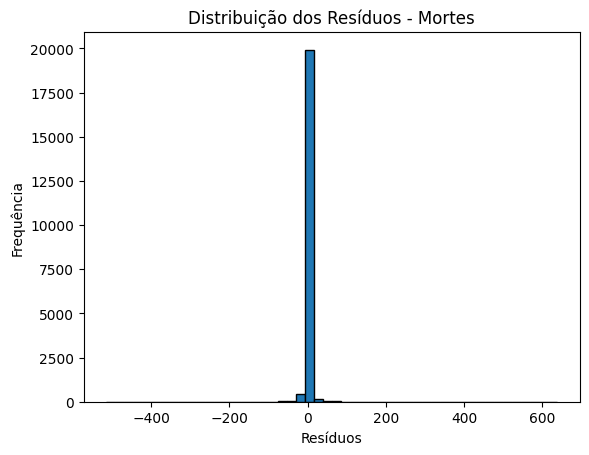

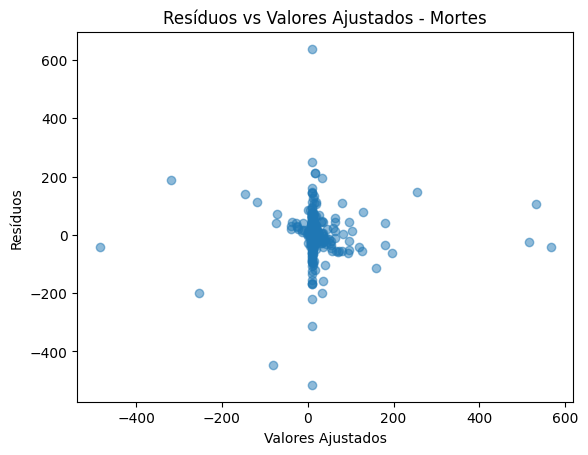

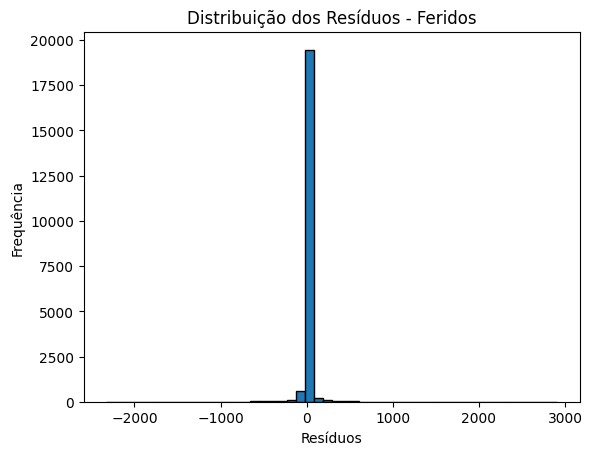

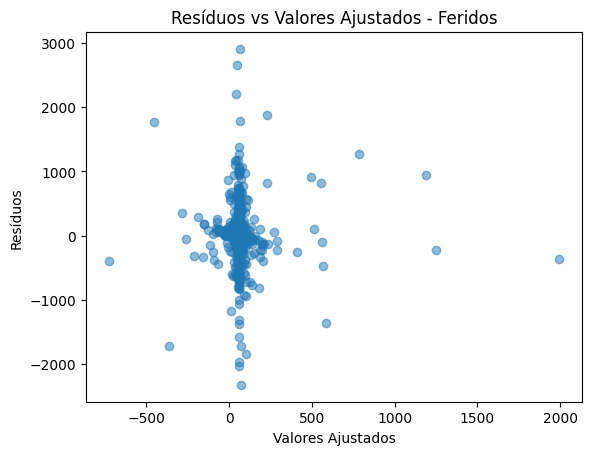

In [55]:
plot_residuos(model_mortes, 'Mortes')

plot_residuos(model_feridos, 'Feridos')

### VIF - correlação agrupada

Medida que verifica o grau de multicolinearidade em cada variável.

A estratégia é detectar variáveis com VIF muito grande (por exemplo >10) e eliminá-las do modelo

Mais detalhes pode ser obtido nos links abaixo

21. https://www.linkedin.com/pulse/vifvariance-inflation-factor-thiago-teles/

22. https://en.wikipedia.org/wiki/Variance_inflation_factor

In [56]:
VIF(X)

,feature,VIF
0,const,1.483505
1,aux_emp_parque_vlr_investimento,1.016993
2,aux_emp_pavimentacao_vlr_investimento,1.850314
3,aux_emp_vlt_vlr_investimento,1.702632
4,aux_emp_aeroporto_vlr_investimento,1.413152
5,aux_emp_refrota_vlr_investimento,1.003976
6,aux_emp_calcamento_vlr_investimento,1.008589
7,aux_emp_sinalizacao_vlr_investimento,2.238757
8,vlr_investimento_per_capita,1.200177
9,aux_emp_terminal_vlr_investimento,3.223360


## Efeitos Aleatórios

Mais informações de como o modelo funciona pode ser visto nos links (1) a (5) e sobre o algoritmo pode ser obtido em:

23. https://bashtage.github.io/linearmodels/panel/panel/linearmodels.panel.model.RandomEffects.html

In [57]:
model_mortes_random = fit_random_effect(X, y_mortes, show_summary=True)

teste_BP(df_panel, 'total_mortes',X.drop('const',axis=1).columns.tolist())

Dep. Variable:,total_mortes,R-squared:,0.2282
Estimator:,RandomEffects,R-squared (Between):,0.1826
No. Observations:,20700,R-squared (Within):,0.3014
Date:,"Mon, Jun 10 2024",R-squared (Overall):,0.2076
Time:,19:58:48,Log-likelihood,-8.969e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,265.80
Entities:,5244,P-value,0.0000
Avg Obs:,3.9474,Distribution:,"F(23,20676)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,277.64




Breusch-Pagan Test for Total total_mortes:
{'LM Statistic': 381.43664725936407, 'LM-Test p-value': 1.1618061613806753e-66, 'F-Statistic': 16.875945200026287, 'F-Test p-value': 2.4335243550665067e-67}

Hipótese de Homoscedasticidade do modelo Pooled  Rejeitada


In [58]:
salva_coeficientes(model_mortes_random)

In [59]:
model_feridos_random = fit_random_effect(X, y_feridos, show_summary=True)

teste_BP(df_panel, 'total_feridos',X.drop('const',axis=1).columns.tolist())

Dep. Variable:,total_feridos,R-squared:,0.0519
Estimator:,RandomEffects,R-squared (Between):,0.0761
No. Observations:,20700,R-squared (Within):,0.0301
Date:,"Mon, Jun 10 2024",R-squared (Overall):,0.0764
Time:,19:58:50,Log-likelihood,-1.302e+05
Cov. Estimator:,Unadjusted,,
,,F-statistic:,49.167
Entities:,5244,P-value,0.0000
Avg Obs:,3.9474,Distribution:,"F(23,20676)"
Min Obs:,1.0000,,
Max Obs:,10.0000,F-statistic (robust):,53.685




Breusch-Pagan Test for Total total_feridos:
{'LM Statistic': 366.23389783950046, 'LM-Test p-value': 1.5203279560870067e-63, 'F-Statistic': 16.191213634043923, 'F-Test p-value': 3.62958990947217e-64}

Hipótese de Homoscedasticidade do modelo Pooled  Rejeitada


In [60]:
salva_coeficientes(model_feridos_random)

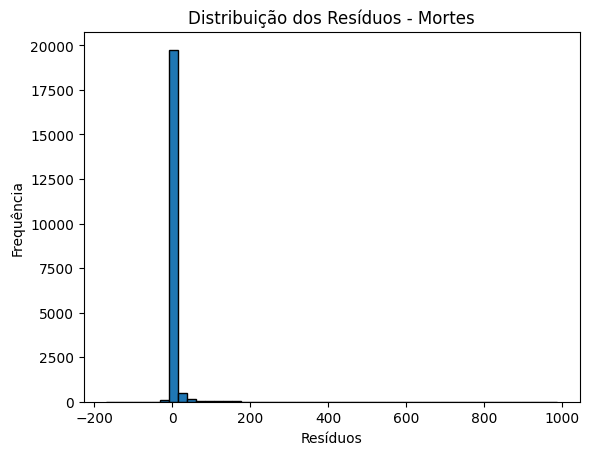

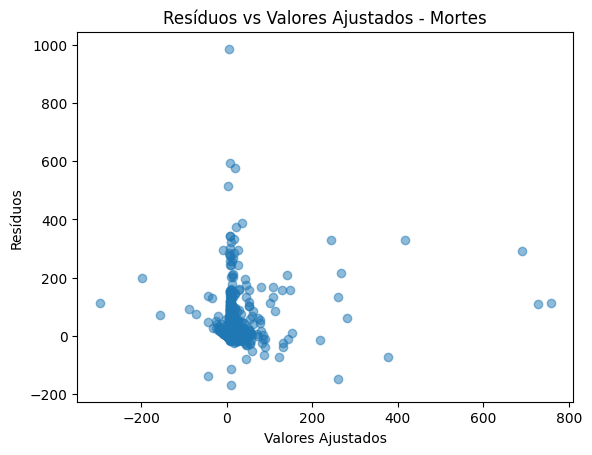

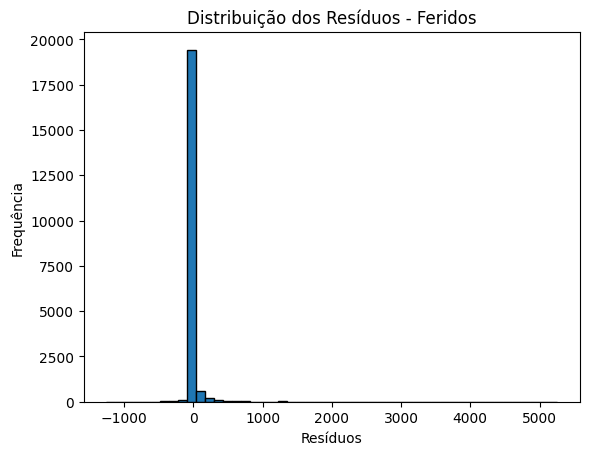

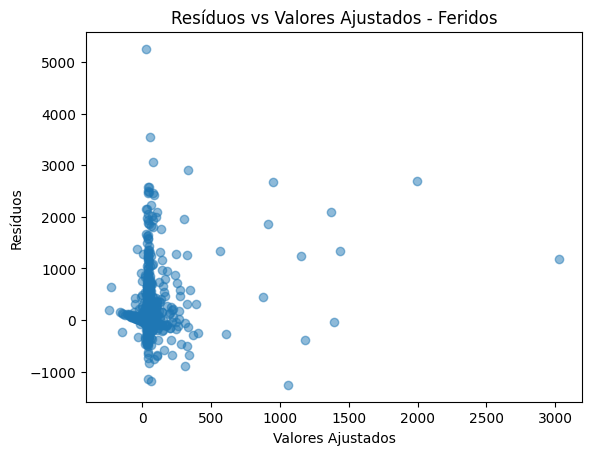

In [61]:
plot_residuos(model_mortes_random, 'Mortes')

plot_residuos(model_feridos_random, 'Feridos')

## Teste de Hausman para escolha do modelo de Efeitos Fixos vs Efeitos Aleatório

Caso as hipóteses nulas sejam rejeitadas nos testes anteriores, procede-se com o Teste de Especificação de Hausman para comparar a consistência entre o Modelo de Efeito Fixo e o Modelo de Efeito Aleatório. 

A hipótese nula do teste sugere que o Modelo de Efeito Aleatório é mais apropriado. 

Caso esta hipótese seja rejeitada, o Modelo de Efeito Fixo é considerado o mais adequado para a análise, enquanto que, se não rejeitado, segue com o modelo de Efeito Aleatório.

Mais detalhes podem ser encontrados nos links de (1) a (5) e no link abaixo 

24. https://pt.wikipedia.org/wiki/Teste_de_especifica%C3%A7%C3%A3o_de_Hausman

In [62]:
compare_random_fixed_panel(X, y_mortes)

,Fixed Effects,Random Effects
Dep. Variable,total_mortes,total_mortes
Estimator,PanelOLS,RandomEffects
No. Observations,20700,20700
Cov. Est.,Unadjusted,Unadjusted
R-squared,0.3661,0.2282
R-Squared (Within),0.3661,0.3014
R-Squared (Between),0.0690,0.1826
R-Squared (Overall),0.1206,0.2076
F-statistic,387.61,265.80
P-value (F-stat),0.0000,0.0000


Teste de Hausman
Estatística chi2: -1900.7492155707023
P-valor: 1.0
Hipótese Nula: Não Rejeitada (Efeitos aleatórios são preferidos)


In [63]:
compare_random_fixed_panel(X, y_feridos)

,Fixed Effects,Random Effects
Dep. Variable,total_feridos,total_feridos
Estimator,PanelOLS,RandomEffects
No. Observations,20700,20700
Cov. Est.,Unadjusted,Unadjusted
R-squared,0.0615,0.0519
R-Squared (Within),0.0615,0.0301
R-Squared (Between),0.0196,0.0761
R-Squared (Overall),0.0300,0.0764
F-statistic,43.977,49.167
P-value (F-stat),0.0000,0.0000


Teste de Hausman
Estatística chi2: -887.1329483482106
P-valor: 1.0
Hipótese Nula: Não Rejeitada (Efeitos aleatórios são preferidos)


Com p-valor = 1 em ambos os testes (para mortos e feridos), é adequado usar o modelo de efeitos aleatórios para os mortos e feridos